In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
monthly_sum_df = pd.read_csv("webbsite_hk_private_cars_monthly_SUM_2020_2025.csv")
monthly_sum_df.head()

,Year,Month,Petrol,Electric,Diesel,Others,Total,EV_share_%
0,2020,1,2208.0,115.0,0.0,0.0,2323.0,4.950495
1,2020,2,1738.0,192.0,0.0,0.0,1930.0,9.948187
2,2020,3,2295.0,589.0,0.0,0.0,2884.0,20.423024
3,2020,4,2115.0,178.0,0.0,0.0,2293.0,7.762756
4,2020,5,2684.0,156.0,0.0,0.0,2840.0,5.492958


In [3]:
monthly_sum_df["date"]  = pd.to_datetime(dict(year=monthly_sum_df["Year"],  month=monthly_sum_df["Month"],  day=1))

In [4]:
monthly_sum_df = monthly_sum_df.sort_values("date").reset_index(drop=True)

In [5]:
monthly_sum_df.tail()

,Year,Month,Petrol,Electric,Diesel,Others,Total,EV_share_%,date
61,2025,2,900.0,2435.0,0.0,0.0,3335.0,73.013493,2025-02-01
62,2025,3,1156.0,2465.0,0.0,1.0,3622.0,68.056322,2025-03-01
63,2025,4,1030.0,2098.0,0.0,0.0,3128.0,67.071611,2025-04-01
64,2025,5,1125.0,3276.0,0.0,0.0,4401.0,74.437628,2025-05-01
65,2025,6,1174.0,3219.0,0.0,0.0,4393.0,73.275666,2025-06-01


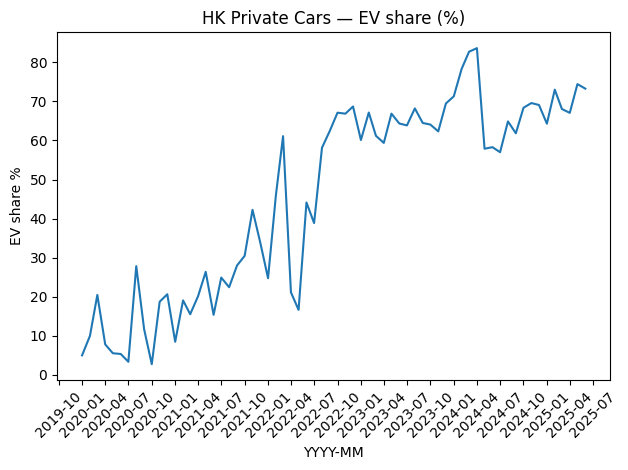

In [6]:
# plot EV share accross all brands from 2020 to 2025.06
import matplotlib.dates as mdates

fig = plt.figure()
ax = plt.gca()
ax.plot(monthly_sum_df["date"], monthly_sum_df["EV_share_%"])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))          
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))          
plt.xticks(rotation=45)

plt.xlabel("YYYY-MM")         
plt.ylabel("EV share %")
plt.title("HK Private Cars — EV share (%)")
plt.tight_layout()
plt.savefig("images_2/Overall_EV_share_trend_2020-2025.png", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
by_month_df = pd.read_csv("website_hk_private_cars_by_month.csv")
by_month_df.head()

,Year,Month,Brand,Petrol,Electric,Diesel,Others,Total
0,2020,1,ALFA ROMEO,1.0,0.0,NaN,0.0,1.0
1,2020,1,ASTON MARTIN,2.0,0.0,NaN,0.0,2.0
2,2020,1,AUDI,83.0,22.0,NaN,0.0,105.0
3,2020,1,B.M.W.,305.0,0.0,NaN,0.0,305.0
4,2020,1,B.M.W.I.,1.0,0.0,NaN,0.0,1.0


In [8]:
by_month_df["date"] = pd.to_datetime(dict(
        year=by_month_df["Year"], month=by_month_df["Month"], day=1))

In [9]:
by_month_df["Brand"] = by_month_df["Brand"].astype(str).str.upper().str.strip()

In [10]:
ev_df = by_month_df.copy()
ev_df["Electric"] = pd.to_numeric(ev_df["Electric"], errors="coerce").fillna(0)

In [11]:
ev_total = (ev_df.groupby("date", as_index=False)["Electric"].sum()
                 .rename(columns={"Electric":"EV_total"}))

In [12]:
Path("images").mkdir(exist_ok=True)

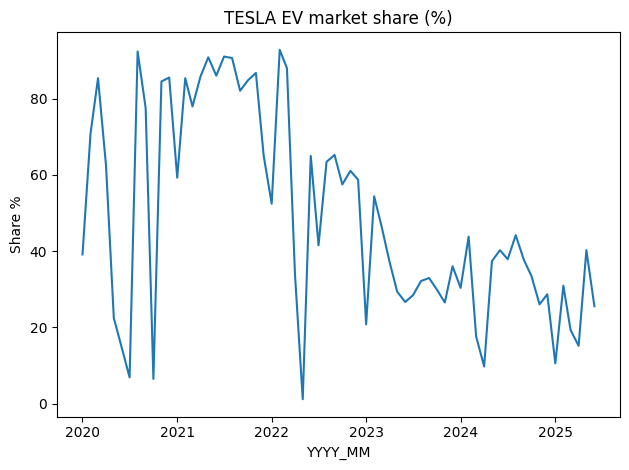

In [13]:
# Tesla's share in EV Market
tesla_m = (ev_df[ev_df["Brand"]=="TESLA"]
           .groupby("date", as_index=False)["Electric"].sum()
           .rename(columns={"Electric":"TESLA"}))
share = tesla_m.merge(ev_total, on="date", how="right").fillna(0)
share["TESLA_share_%"] = np.where(share["EV_total"]>0, share["TESLA"]/share["EV_total"]*100, np.nan)

plt.figure()
plt.plot(share["date"], share["TESLA_share_%"])
plt.title("TESLA EV market share (%)")
plt.xlabel("YYYY_MM")
plt.ylabel("Share %") 
plt.tight_layout()
plt.savefig("images_2/tesla_ev_share_trend.png", dpi=300, bbox_inches="tight")
plt.show()

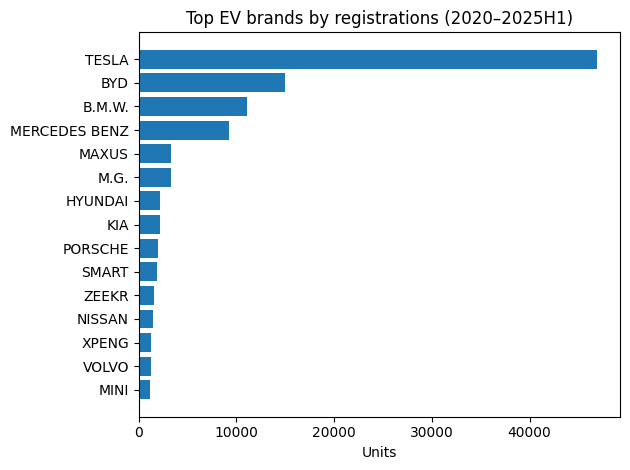

,Brand,Electric
94,TESLA,46906.0
13,BYD,14938.0
8,B.M.W.,11055.0
66,MERCEDES BENZ,9260.0
62,MAXUS,3310.0
60,M.G.,3307.0
42,HYUNDAI,2225.0
52,KIA,2203.0
79,PORSCHE,1940.0
89,SMART,1848.0


In [14]:
# Top_ev_brands in tatalsales across 2020-2025H1
mask = ev_df["date"].between(pd.Timestamp("2020-01-01"), pd.Timestamp("2025-06-30"))
top_ev = (ev_df[mask].groupby("Brand", as_index=False)["Electric"].sum()
          .sort_values("Electric", ascending=False).head(15))

plt.figure()
plt.barh(top_ev["Brand"][::-1], top_ev["Electric"][::-1])
plt.title("Top EV brands by registrations (2020–2025H1)")
plt.xlabel("Units")
plt.tight_layout()
plt.savefig("images_2/top_ev_brands_2020_2025H1.png", dpi=300, bbox_inches="tight")
plt.show()

top_ev.head(20)  

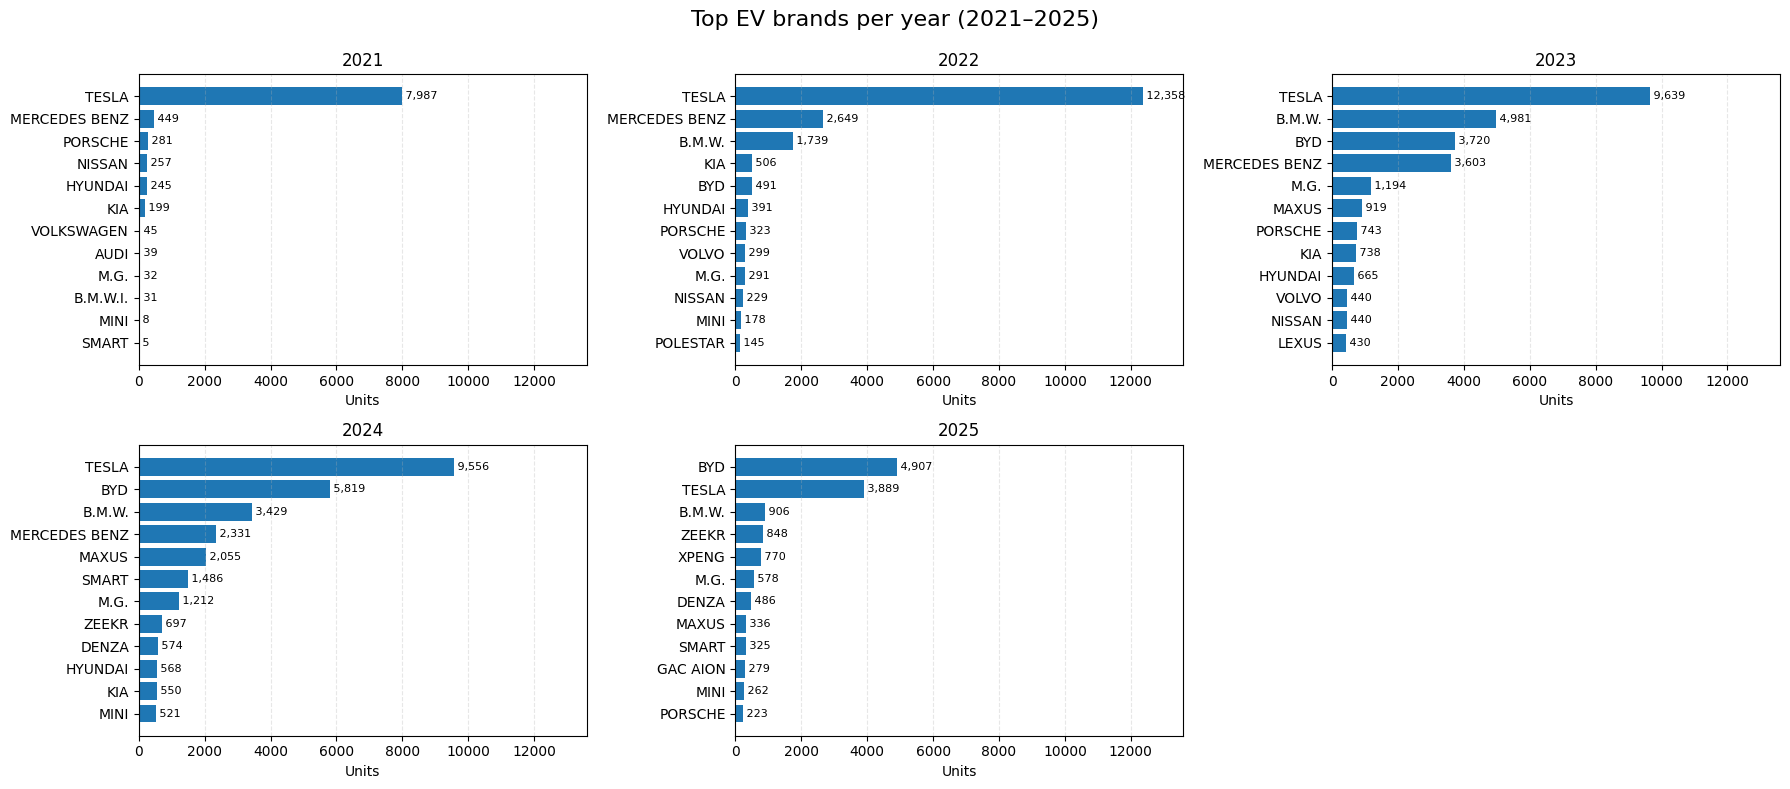

In [15]:
# top_ev_brands_panel_2021_2025 across all brands
import math, numpy as np

years = [y for y in sorted(ev_df["Year"].unique()) if 2021 <= y <= 2025]
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), sharex=False)
axes = np.array(axes).ravel()

xmax = 0
year_tops = []
for y in years:
    t = (ev_df[ev_df["Year"]==y].groupby("Brand", as_index=False)["Electric"].sum()
         .sort_values("Electric", ascending=False).head(12))
    year_tops.append((y,t))
    if len(t): xmax = max(xmax, float(t["Electric"].max()))

for i, (y,t) in enumerate(year_tops):
    ax = axes[i]
    ax.barh(t["Brand"][::-1], t["Electric"][::-1])
    ax.set_title(str(y), fontsize=12, pad=6)
    ax.set_xlabel("Units")
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    ax.set_xlim(0, xmax*1.1)
    vals = t["Electric"][::-1].to_numpy()
    for j,v in enumerate(vals):
        ax.text(v, j, f" {int(v):,}", va="center", ha="left", fontsize=8)

for j in range(len(years), rows*cols):
    fig.delaxes(axes[j])

fig.suptitle("Top EV brands per year (2021–2025)", fontsize=16, y=0.98)
plt.tight_layout(); plt.subplots_adjust(top=0.90)
plt.savefig("images_2/top_ev_brands_panel_2021_2025.png", dpi=300, bbox_inches="tight")
plt.show()

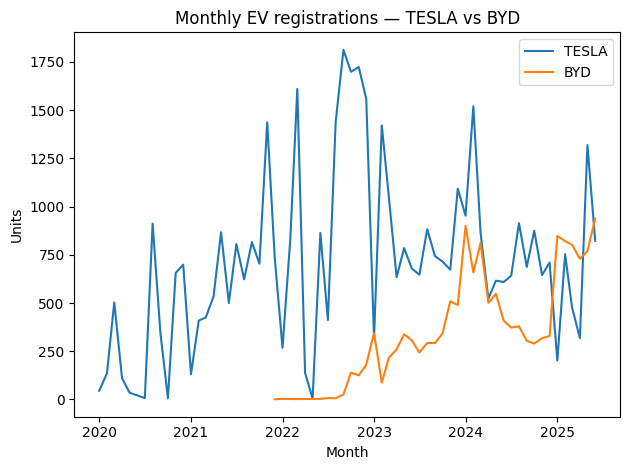

In [16]:
# compare Tesla and BYD 
watch = ["TESLA", "BYD"] 
fig = plt.figure()
for b in watch:
    s = (ev_df[ev_df["Brand"]==b]
         .groupby("date", as_index=False)["Electric"].sum()
         .sort_values("date"))
    plt.plot(s["date"], s["Electric"], label=b)

plt.legend()
plt.title("Monthly EV registrations — TESLA vs BYD")
plt.xlabel("Month")
plt.ylabel("Units")
plt.tight_layout()
plt.savefig("images_2/ev_monthly_tesla_vs_byd.png", dpi=300, bbox_inches="tight")
plt.show()